## A very short introduction to convex optimization

Here I cover a basic introduction to concepts and theory of convex optimization. The goal is to give an impression of why this is an important area of optimization, what its applications are, and some intiution for how it works. This is of course not meant to overview all areas of convex optimization, but more to give a flavor of the area by describing some results and theory as they relate to other areas that may be familiar to people (e.g. Lagrange multipliers). By presenting this in a notebook the aim is to focus on providing some geometric intuition whenever possible through plots whose parameters you can play with. Images not generated in this notebook are taken from one of the standard references: [Convex Optimization](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf), by Boyd and Vandenberghe. 

Here I will cover:

### Contents

**Part A.**
1. Basics of convex functions and sets
2. Why care about convexity?
3. A convergence proof of gradient descent

**Part B.**
1. Conjugate functions
2. The Lagrangian dual problem
3. Generalizing Lagrange multipliers: the KKT conditions

## Part A

Most machine learning problems end up as some form of optimization problem, thus a basic understanding of optimization methods is very useful, or sometimes necessary, to solve a given problem. 

For instance, in simple linear regression, given some data $(y, X)$ and a model $y \sim X\beta + \epsilon$, we aim to find the weights $\beta$ that minimize:
$$
\beta^* = \text{argmin}_\beta \|y - X\beta\|^2_2.
$$

In general, we consider the following basic problem:
$$
x^* = \text{argmin}_{x\in\mathcal{X}} f(x)
$$
subject to constraints:
$$
g_i(x) \le 0\\
h_j(x) = 0.
$$
Convex optimization deals with problems in which $f(x)$ and $g_i(x)$ are convex functions, and $h_j(x)$ are affine (of the form $a_j^Tx = b_j$).

What is a convex function?

### 1. Basics of convex functions and sets

A convex *set* is a set $C$ in which the line segment connecting any two points in the set is also in the set. That is, if $x_1,x_2\in C$ and $0\le \theta \le t$ then
$$
\theta x_1 + (1-\theta)x_2 \in C.
$$
Some examples:
![title](assets/convexset.png)

A *function* $f:\mathbb{R}^n\to\mathbb{R}$ is convex if $\text{dom} f$ is convex and for $0\le \theta \le 1, x_1, x_2 \in \text{dom} f$:
$$
f(\theta x_1 + (1-\theta)x_2) \le \theta f(x_1) + (1-\theta) f(x_2)
$$

This means that a line segement connecting any two points in the domain of $f$ lies above the graph of $f$:
![](./assets/convexfunc.png)

### An alternative definition

If $f$ is differentiable, then $f$ is convex if and only if $\text{dom} f$ is convex and 
$$
f(x_2) \ge f(x_1) + \nabla f(x)^T(x_2-x_1)
$$
holds for all $x_1,x_2\in\text{dom} f$.

![](./assets/convexfunc2.png)

This means local information of a convex function can tell us about global information of the function -- this is a key property of convex functions. 

For instance, if $\nabla f(x) = 0$ then for all $y\in\text{dom} f$ it is the case that $f(y) \ge f(x)$. In other words, $x$ is a global minimizer of $f$.

A few more definitions:

**Strict convexity**

A function $f$ is *strictly convex* if the inequality holds whenever $x_1\ne x_2$. I.e. a linear function is not strictly convex

**Strong convexity**

*Strong convexity* implies there is some positive $m$ such that:
$$
\nabla^2 f(x) \succeq mI
$$
which can be shown to be equivalent to
$$
f(x) \ge f(x_1) + \nabla f(x_1)^T(x-x_1) + \frac{m}{2}\|x - x_1\|^2_2
$$
for all $x_1,x\in \mathcal{X}$. 

This means the function can be lower bounded by a quadratic function with some fixed second derivative $mI$.

For instance, in one dimension, $f(x) = x^2$ is strongly convex, but $f(x) = e^x$ is not. 

In [4]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output

### Some examples of convex functions

In [27]:
def plot_heatmap(f, dom_x, dom_y, resolution = 100, title = None):
    x = np.linspace(*dom_x, resolution)
    y = np.linspace(*dom_y, resolution)
    xx, yy = np.meshgrid(x, y)
    im = f(xx,yy)
    plt.imshow(im, origin = 'lower')
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    if title: plt.title(title)

1. Indicator function of a convex set, $S$. 

If $I_S(x)$ is defined as
$$
I_S(x) = \begin{cases}
0, \quad x\in S;\\
+\infty, \quad\text{else}
\end{cases}
$$
Then $I_S(x)$ is convex

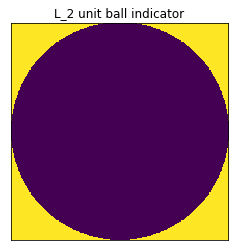

In [28]:
%matplotlib inline
f = lambda x,y: 1 - ((x**2 + y**2) < 1)
plot_heatmap(f, [-1,1], [-1,1], resolution = 500, title = "L_2 unit ball indicator")

2. Norms. Any norm is a convex function:

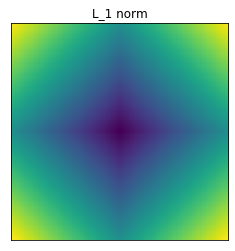

In [49]:
l1 = lambda x,y: abs(x) + abs(y)
plot_heatmap(l1, [-1,1], [-1,1], title = "L_1 norm")

3. Quadratic functions: $f(x) = x^T P x + 2q^T x + r$ for $P$ positive definite.

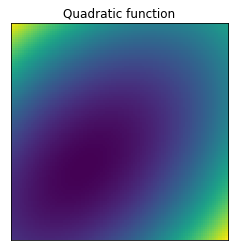

In [50]:
f = lambda x,y: x**2 - x*y + y**2 + x + y
plot_heatmap(f, [-3,3], [-3,3], title = "Quadratic function")

4. Common functions: $1/x$ for $x>0$, $e^x$ for $x\in\mathbb{R}$, $x^2$ for $x\in\mathbb{R}$.

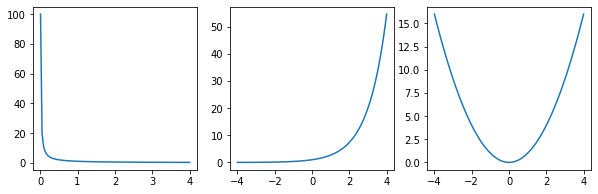

In [61]:
fig, axes = plt.subplots(1, 3, figsize = (10,3))
xx = np.linspace(0.01, 4, 100)
axes[0].plot(xx, 1/xx);
xx = np.linspace(-4, 4, 100)
axes[1].plot(xx, np.exp(xx));
axes[2].plot(xx, xx**2);

### Examples of strong convexity

In [26]:
def make_widget_mx1(f, f_prime):
    %matplotlib widget

    fig, ax = plt.subplots(figsize = (3,3));
    xx = np.linspace(-4, 4, 100)
    ax.plot(xx, f(xx))

    x1 = 0
    m = 1
    yy = f(x1) + f_prime(x1)*(xx-x1) + m/2*(xx - x1)**2
    line, = ax.plot(xx, yy)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['f(x)', 'lower bound'])

    def myplot(x1, m):
        yy = f(x1) + f_prime(x1)*(xx-x1) + m/2*(xx - x1)**2
        line.set_ydata(yy)
        ax.relim()
        display(fig)
        clear_output(wait=True)

    widgets.interact(myplot, x1=(-4,4,.1), m = (0, 2,0.2));

In [31]:
f = lambda x: x**2
f_prime = lambda x: 2*x
make_widget_mx1(f, f_prime)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='x1', max=4.0, min=-4.0), FloatSlider(value=1.0, desc…

$f(x) = x^2$, somewhat trivally, *is* a strongly convex function.

In [32]:
f = lambda x: np.exp(x)
f_prime = f
make_widget_mx1(f, f_prime)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='x1', max=4.0, min=-4.0), FloatSlider(value=1.0, desc…

$f(x) = \exp(x)$ is *not* a strongly convex function. The general idea being something like functions that become arbitarily flat/linear in some direction are not strongly convex.

### Operations that preserve convexity

1. Non-negative weighted sums.

If $f_i$ are each convex, then the nonnegative weighted sum:
$$
f(x) = \sum_i w_i f_i(x)
$$
is convex, for $w_i \ge 0$.

2. Composition with nondecreasing functions.

Let $f = h(g(x))$. If $h$ is a scalar function, $h:\mathbb{R}\to\mathbb{R}$, then:

For example, if $h$ is convex and nondecreasing, and $g$ is convex, then $f$ is convex.

3. Pointwise maxima.

If $f_1$ and $f_2$ are convex, then the pointwise maximum:
$$
f(x) = \max\{f_1(x), f_2(x)\}
$$
is also convex. The proof is simple:
$$
\begin{align}
f(\theta x + (1-\theta)y) &= \max\{f_1(\theta x + (1-\theta)y), f_2(\theta x + (1-\theta)y)\}\\
&\le \max\{\theta f_1(x) + (1-\theta)f_1(y), \theta f_2(x) + (1-\theta)f_2(y)\}\quad\text{(conv. of $f_1,f_2$)}\\
&\le \theta\max\{ f_1(x), f_2(x) \} + (1-\theta)\max\{f_1(y),f_2(y)\}\quad\text{(replace $f_1$ w. max $f_1,f_2$)}\\
&= \theta f(x) + (1-\theta) f(y)
\end{align}
$$

This result extends to pointwise maximum over $n$ functions:
$$
f(x) = \max\{(f_i(x)\}_{i=1}^n
$$

and also the pointwise supremum over an infinite set of convex functions. Let $\{f_i(x)\}_{i\in I}$ be a collection of convex functions, then
$$
g(x) = \sup_{i\in I}f_i(x)
$$
is convex.

### 2. Why care about convex optimization?

1. When your problem is convex, a locally optimal solution is globally optimal -> Can use gradient-based methods confidently
2. Shows up in common optimization problems
  * Linear least squares
  * Logistic regression
  * Weighted least squares
3. A lot of associated theory and strong geometric intuition can provide a good understanding of the problem
4. Can be relevant even for non-convex problems:
  * Can turn into a convex problem (primal -> dual problem, see below)
  * Can approximate with a convex function to initialize a local optimization method
  * Common heuristics: convex relaxation for finding sparse solutions, e.g. $L_0$ to $L_1$ relaxation
  * Bounds for global optimization
5. Concepts that naturally arise in convex optimization are important elsewhere, like the theory of Lagrangians

Somewhat like linear algebra, because you can do a lot with convex optimization, it is quite foundational to optimization and important to know. 

### 3. Convergence of gradient descent

For a strongly convex function that satisfies:
$$
\alpha I \preceq \nabla^2 f(x) \preceq \beta I
$$
for all $x\in\mathcal{X}$ and $0<\alpha \le \beta$. An equivalent condition is for
$$
f(y) \ge f(x) + \nabla f(x)(y-x) + \frac{\alpha}{2}\|y-x\|^2,\quad \forall x,y\in\mathcal{X}
$$
known as $\alpha$-strongly convex. And 
$$
f(y) \le f(x) + \nabla f(x)(y-x) + \frac{\beta}{2}\|y-x\|^2,\quad \forall x,y\in\mathcal{X}
$$
Known as $\beta$-smoothness.

In other words, for all points $x\in\mathcal{X}$, the function $f(y)$ can be bounded below and above by quadratic functions intersecting at $f(x)$.

This can be used to show the following inequalities:
$$
\begin{align}
\frac{\alpha}{2}\|x^* - x\|^2&\le f(x) - f(x^*) \le \frac{1}{2\alpha}\|\nabla f(x)\|^2\quad \text{$\alpha$-strongly convex}\\
\frac{\beta}{2}\|x^* - x\|^2&\ge f(x) - f(x^*) \ge \frac{1}{2\beta}\|\nabla f(x)\|^2\quad\text{$\beta$-smoothness}\\
\end{align}
$$

Call the quantity $h(x) = f(x)-f(x^*)$ the *primal gap*, the thing we are trying to reduce in our optimization. 

These inequalities are useful because they let us bound the primal gap by the gradient and the amount we're moving in $x$ (a property of the algorithm, which is known).


Now consider the gradient descent update:
$$
x_{t+1} = x_t - \frac{1}{\beta}\nabla f(x_t)
$$

Then the above inequalities can be used to show how the primal gap converges:
$$
\begin{align}
h_{t+1} - h_t &= f(x_{t+1}) - f(x_t)\\
&\le \nabla f(x_t)(x_{t+1}-x_t) + \frac{\beta}{2}\|x_{t+1}-x_t\|^2\quad (\text{$\beta$-smoothness})\\
&= -\frac{1}{\beta}\|\nabla f(x_t)\|^2 + \frac{1}{2\beta}\|\nabla f(x_t)\|^2\quad (\text{definition of algorithm})\\
&= -\frac{1}{2\beta}\|\nabla f(x_t)\|^2\quad\\
&\le -\frac{\alpha}{\beta}h_t\quad\\
\end{align}
$$
Thus 
$$
h_{t+1} = h_t(1 - \frac{\alpha}{\beta}), 
$$
or
$$
h_{t} = h_0(1 - \frac{\alpha}{\beta})^t.
$$
Since $\alpha < \beta$ then the algorithm converges. Further, how close $\alpha$ is to $\beta$ determines the convergence rate -- convergence is fastest when $\alpha$ is close to $\beta$... this corresponds to the Hessian being closed to spherical (well-conditioned).

In [95]:
def make_widget_gd():
    %matplotlib widget

    fig, axes = plt.subplots(1, 2, figsize = (10,5));
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    xx, yy = np.meshgrid(x, y)

    ax = axes[0]
    alpha = 1
    beta = 5
    f = lambda x, y: (alpha * x**2 + beta * y**2)/2
    zz = f(xx, yy)
    ax.imshow(zz, extent = (-4, 4, -4, 4))

    #Run GD n times
    theta = np.array([3,3])
    n = 7
    theta_hist = np.zeros((n, 2))
    f_hist = np.zeros(n)
    for idx in range(n):
        theta_hist[idx,:] = theta
        f_hist[idx] = f(*theta)
        theta = theta - np.array([alpha*theta[0], beta*theta[1]])/(0.8*beta)
    #Plot the progress of the optimization    
    line, = ax.plot(*theta_hist.T, color = 'red')

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    line2, = axes[1].plot(f_hist)
    axes[1].set_yscale('log')
    axes[1].set_ylim([0.001,20])
    
    #Replot with new params
    def myplot(alpha, beta):

        f = lambda x, y: (alpha * x**2 + beta * y**2)/2
        zz = f(xx, yy)
        ax.imshow(zz, extent = (-4, 4, -4, 4))

        theta = np.array([3,3])
        theta_hist = np.zeros((n, 2))
        f_hist = np.zeros(n)
        for idx in range(n):
            theta_hist[idx,:] = theta
            f_hist[idx] = f(*theta)
            theta = theta - np.array([alpha*theta[0], beta*theta[1]])/(1.1*beta)

        line.set_xdata(theta_hist[:,0])
        line.set_ydata(theta_hist[:,1])
        line2.set_ydata(f_hist)
        ax.relim()
        display(fig)
        clear_output(wait=True)#

    widgets.interact(myplot, alpha=(0,2,.1), beta = (0, 4,0.2));

As an example, consider the quadratic function:
$$
f(x,y) = \frac{m_x}{2}x^2 + \frac{m_y}{2}y^2.
$$
This is strongly convex, with $\alpha = \min(m_x, m_y)$ and $\beta = \max(m_x, m_y)$. We observe the convergence behavior (the primal gap as a function of gradient descent iteration). Apart from the first iteration, it's linear on a log scale, as the above analysis would suggest. The slope depends on the ratio between $\alpha$ and $\beta$.

In [96]:
make_widget_gd()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=1.0, description='alpha', max=2.0), FloatSlider(value=2.0, description…

## Part B.

Here we explore how some theory of convex functions and optimization relates to a common and powerful method in optimization -- Lagrange multipliers

### 1. Conjugate functions


Let $f:\mathbb{R}^n\to\mathbb{R}$, then we can define $f^*:\mathbb{R}^n\to\mathbb{R}$ as
$$
f^*(\lambda) = \sup_{x\in\text{dom} f} (\lambda^T x - f(x)).
$$
As this is the pointwise supremum over a set of convex (linear) functions, it is itself convex. This is true regardless of whether $f$ is convex. This is known as the conjugate of $f$.

How can this be convex even if $f$ is not? Here's one example:

Consider the non-convex function $f(x) = x^2(x-1)(x+1)$

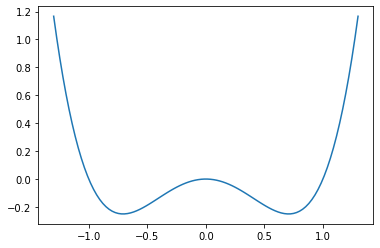

In [101]:
%matplotlib inline
f = lambda x: x**2*(x-1)*(x+1)

xx = np.linspace(-1.3,1.3,100)
yy = f(xx)
plt.plot(xx,yy);

It's conjugate is obtained through computing the following maximum:

In [124]:
def make_widget_conjugate(res = 100):
    %matplotlib widget
    
    fig, axes = plt.subplots(1, 2, figsize = (10,5));
    xx = np.linspace(-1.3, 1.3, res)

    y = 1
    f = lambda x: x**2*(x-1)*(x+1)

    fstar = lambda x, y: x*y - f(x)
    yy = fstar(xx, y)
    l1, = axes[0].plot(xx,yy)
    
    idx_star = np.argmax(yy)
    x_star = xx[idx_star]
    y_star = np.max(yy)
    
    l2, = axes[0].plot(x_star, y_star, '.', color = 'red')

    axes[0].set_xlabel('x')
    axes[0].set_title('yx - f(x)')
    
    y_range = np.linspace(-2, 2, res)
    fstar_all = np.zeros(res)
    for idx, ys in enumerate(y_range):
        fstar_all[idx] = np.max(fstar(xx, ys))
        
    axes[1].plot(y_range, fstar_all)
    l3, = axes[1].plot(y, y_star, '.', color = 'red')
    
    axes[1].set_xlabel('y')
    axes[1].set_title('f^*(y)')

    #Replot with new params
    def myplot(y):

        yy = fstar(xx, y)
        l1.set_ydata(yy)

        idx_star = np.argmax(yy)
        x_star = xx[idx_star]
        y_star = np.max(yy)

        l2.set_ydata(y_star)
        l2.set_xdata(x_star)
        l3.set_ydata(y_star)
        l3.set_xdata(y)

        ax.relim()
        display(fig)
        clear_output(wait=True)#

    widgets.interact(myplot, y = (-2, 2, 0.1));

In [125]:
make_widget_conjugate()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='y', max=2.0, min=-2.0), Output()), _dom_classes=('wi…

Which is clearly convex.

### Some more examples

1. Affine functions. If $f(x) = ax+b$ then $f^*:\{a\}\to\mathbb{R}$ and $f^*(a) = -b$
2. Exponential. If $f(x) = \exp(x)$ then $f^*:\mathbb{R}_+\to\mathbb{R}$ and $f^*(x) = x\log x - x$
3. Negative entropy. If $f(x) = x\log x$ then $f^*(x) = \exp(x-1)$.

If $f(x)$ is convex, then (given some additional technical condtions), $f(x) = f^{**}(x)$, justifying the use of the term conjugate.

### 2. The Lagrangian dual problem

### 3. Generalizing Lagrange multipliers: the KKT conditions